In [59]:
import random
import pickle
import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from feature_extractor import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

## Flag 1

In [3]:
with open("matrix.pickle","rb") as f:
    matrix = pickle.load(f)

In [57]:
# adapted from sklearn official website
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          classes=["True Edge","Fake Edge"],
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def feature_generator(pairs):
    
    X = []
    for datum in tqdm(pairs):
        a, b = datum

        # node feature
        a_in = indegree(a, matrix)
        a_out = outdegree(a, matrix)
        b_in = indegree(b, matrix)
        b_out = indegree(b, matrix)

        # neighbouring feature
        neighbour = common_neighbour(a, b, matrix)
        jac = jaccard(neighbour, a, b, matrix)
        dice = dice_idx(neighbour, a, b, matrix)
        p_a = pref_attach(a, b, matrix)
        cos = cosine_sim(neighbour, p_a)
        lhn = LHN(neighbour, p_a)
        adar = adamic_adar(a, b, matrix)
        ra = resource_allocation(a, b, matrix)
        reverse = reverse_link(a, b, matrix)
        hp = hub_promoted(neighbour, a, b, matrix)
        hd = hub_depressed(neighbour, a, b, matrix)

        # path feature
        #sim_r = sim_rank(a, b, matrix, 0)

        flow1, flow2, flow3 = propflow(a, b, matrix)

        X.append([a_in,a_out,b_in,b_out,neighbour,jac,dice,p_a,cos,lhn,adar,reverse,hp,hd,flow1,flow2,flow3])
        
    return X

## Flag 2

In [35]:
X_train = np.load("Xtrain")#[:,:-3]
X_test = np.load("Xtest")#[:,:-3]
y_train = np.load("ytrain")
y_test = np.load("ytest")

In [36]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.8139896373056995


In [37]:
rf.feature_importances_

array([0.10784228, 0.16855443, 0.07429869, 0.07283291, 0.00676313,
       0.00806428, 0.00931545, 0.01057246, 0.0222128 , 0.01879054,
       0.00379632, 0.00880711, 0.02789761, 0.00392057, 0.22426986,
       0.23206156])

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(verbose=1)
gbdt.fit(X_train, y_train)
print(gbdt.score(X_test, y_test))

      Iter       Train Loss   Remaining Time 
         1           1.3567            1.09s
         2           1.3325            1.27s
         3           1.3124            1.19s
         4           1.2948            1.22s
         5           1.2804            1.19s
         6           1.2681            1.13s
         7           1.2573            1.09s
         8           1.2476            1.06s
         9           1.2392            1.04s
        10           1.2310            1.02s
        20           1.1848            0.73s
        30           1.1646            0.59s
        40           1.1500            0.46s
        50           1.1403            0.39s
        60           1.1328            0.31s
        70           1.1255            0.22s
        80           1.1198            0.15s
        90           1.1139            0.07s
       100           1.1093            0.00s
0.673


In [11]:
base = GradientBoostingClassifier()
parameters = {"learning_rate":[0.05,0.1,0.15,0.2,0.3],
              "max_depth":[2,3,5,7],
              "min_samples_leaf":[1,3,5]}
model = GridSearchCV(base, parameters, n_jobs=-1)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.7979274611398963


In [38]:
base = RandomForestClassifier(n_estimators=100)
parameters = {
    "max_depth":[9,11,13,15,17],
    "min_samples_leaf":[1,3,5],
    "min_samples_split":[2,4,6,8,10],
}
model = GridSearchCV(base, parameters, n_jobs=-1)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.8134715025906736


In [39]:
print(roc_auc_score(y_test, np.squeeze(model.predict_proba(X_test)[:,1])))

0.884317696355822


In [19]:
(model.predict(X_test) == 0).sum()

560

In [32]:
model.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
model.best_estimator_.feature_importances_

array([0.08830526, 0.10472676, 0.10816217, 0.10717478, 0.0099624 ,
       0.06074504, 0.03634302, 0.0333932 , 0.06272544, 0.07480472,
       0.01487089, 0.05590122, 0.06415815, 0.03276334, 0.14596361])

## prepare submission

In [1]:
with open("test-public.txt","r") as f:
    test = f.readlines()

X_t = []
for l in test[1:]:
    temp = list(map(int, l.split()))
    X_t.append([temp[1], temp[2]])
print(len(X_t))

2000


In [7]:
X_t = np.array(feature_generator(X_t))

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:37:21<00:00,  2.92s/it]


In [8]:
X_t.dump("Xt")

In [40]:
X_t = np.load("Xt")

In [41]:
y_pred = model.predict(X_t)
(y_pred == 0).sum()

1167

In [35]:
y_pred_prob = model.predict_proba(X_t)

In [36]:
with open("pred.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(1,len(y_pred_prob)+1):
        f.write(str(i) + "," + str(y_pred_prob[i-1][1]) + "\n")

## xgboost

In [42]:
import xgboost

In [43]:
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
print(roc_auc_score(y_test, np.squeeze(xgb.predict_proba(X_test)[:,1])))

0.917348173604472


In [44]:
y_pred = xgb.predict(X_t)
(y_pred == 0).sum()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1145

In [45]:
y_pred_prob = xgb.predict_proba(X_t)

with open("pred.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(1,len(y_pred_prob)+1):
        f.write(str(i) + "," + str(y_pred_prob[i-1][1]) + "\n")

In [50]:
params = {"learning_rate":[0.03,0.1,0.15,0.2,0.3],
          "max_depth":[4,6,7,8,10],
          "subsample":[0.5,0.75,1],
          "colsample_bylevel":[0.5,0.75,1],
          "booster":["gbtree","dart"]}

base = xgboost.XGBClassifier(n_estimators=100)
xgb_ = GridSearchCV(base,params,n_jobs=-1,scoring='roc_auc',verbose=2)
xgb_.fit(X_train, y_train)
print("done!")

Fitting 3 folds for each of 450 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 15.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.03, 0.1, 0.15, 0.2, 0.3], 'max_depth': [4, 6, 7, 8, 10], 'subsample': [0.5, 0.75, 1], 'colsample_bylevel': [0.5, 0.75, 1], 'booster': ['gbtree', 'dart']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [52]:
xgb_.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
       colsample_bytree=1, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [55]:
y_pred = xgb_.predict(X_test)
(y_pred == 0).sum()

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1076

0.921358082909141
Confusion matrix, without normalization
[[900 114]
 [176 740]]


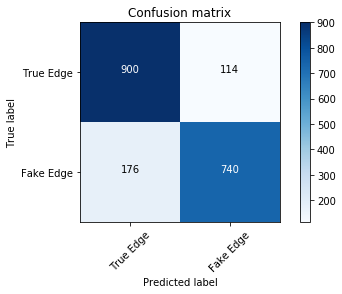

In [61]:
print(roc_auc_score(y_test, np.squeeze(xgb_.predict_proba(X_test)[:,1])))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)
plt.show()

In [49]:
y_pred_prob = xgb_.predict_proba(X_t)
with open("pred.csv","w") as f:
    f.write("Id,Prediction\n")
    for i in range(1,len(y_pred_prob)+1):
        f.write(str(i) + "," + str(y_pred_prob[i-1][1]) + "\n")